## <span style='color:purple '> 1. Import Libraries </span>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#set floating point precision option for pandas
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context('paper', font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller, pacf

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error
%matplotlib inline

import math

#Import necessary functions from keras
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

#to read zipfile
import zipfile

#to check missing values
import missingno as mn

## <span style ='color:purple'> 2. Import Data </span>

In [9]:
zip_file_path = 'cosumption_data.zip'
file_name = 'household_power_consumption.txt'

with zipfile.ZipFile(zip_file_path,'r') as folder:
    file_list = folder.namelist()
    for file in file_list:
        if file == file_name:
            with folder.open(file_name) as csv_file:
                df = pd.read_csv(csv_file, delimiter=';')
    

In [10]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [25]:
df.tail()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
2075254,26/11/2010,20:58:00,0.9460,0.0000,240.4300,4.0000,0.0000,0.0000,0.0000,2010-11-26 20:58:00
2075255,26/11/2010,20:59:00,0.9440,0.0000,240.0000,4.0000,0.0000,0.0000,0.0000,2010-11-26 20:59:00
2075256,26/11/2010,21:00:00,0.9380,0.0000,239.8200,3.8000,0.0000,0.0000,0.0000,2010-11-26 21:00:00
2075257,26/11/2010,21:01:00,0.9340,0.0000,239.7000,3.8000,0.0000,0.0000,0.0000,2010-11-26 21:01:00
2075258,26/11/2010,21:02:00,0.9320,0.0000,239.5500,3.8000,0.0000,0.0000,0.0000,2010-11-26 21:02:00


In [11]:
df.shape

(2075259, 9)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [26]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
Datetime                     0
dtype: int64

## <span style ='color:purple'> 3. Feature Engineering </span>

* Convert 'Date' and 'Time' column to single 'Datetime' column

In [13]:
df['Datetime'] = pd.to_datetime(df['Date']+' '+df['Time'])

In [24]:
df['Datetime'].dtype

dtype('<M8[ns]')

* Convert other features to numeric format

In [32]:
for feat in df.columns.drop(['Date','Time','Datetime']):
    df[feat] = pd.to_numeric(df[feat],errors='coerce')

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 158.3+ MB


* Handling Missing Values

In [34]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

<AxesSubplot:>

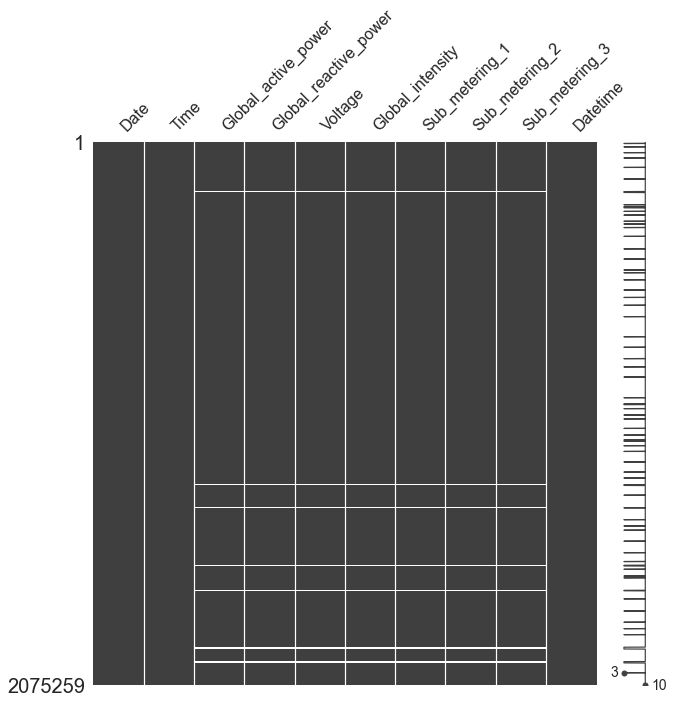

In [36]:
mn.matrix(df,figsize=(10,10))

In [45]:
print('Missing data :',round((df['Global_active_power'].isna().sum()/df.shape[0])*100,2),'%')

Missing data : 1.25 %


* data is missing in chunks and less that 5% data is missing so we can drop the data

In [47]:
df.dropna(inplace=True)

In [53]:
df.shape

(2049280, 14)

* Create new columns for year, quarter, month, and day

In [48]:
df['year'] = df['Datetime'].apply(lambda x: x.year)
df['quarter'] = df['Datetime'].apply(lambda x: x.quarter)
df['month'] = df['Datetime'].apply(lambda x: x.month)
df['day'] = df['Datetime'].apply(lambda x: x.day)

* selecting necessary columns only 

In [49]:
df_2 = df.loc[:,['Datetime','Global_active_power','year','quarter','month','day']]

* Sort data by datetime in ascending order

In [50]:
df_2.sort_values('Datetime',inplace=True, ascending=True)

* Reset the index

In [51]:
df_2 = df_2.reset_index(drop=True)

* Create new column 'weekday' that indicates if the day is weekday or weekend

In [52]:
df_2['weekday'] = df_2['Datetime'].apply(lambda x:x.weekday()<5).astype(int)

In [54]:
print("Minimun datetime :", df_2.Datetime.min())
print("Maximum datetime :", df_2.Datetime.max())

Minimun datetime : 2006-12-16 17:24:00
Maximum datetime : 2010-12-11 23:59:00


In [57]:
df_2.head()

,Datetime,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


In [58]:
df_2.tail()

,Datetime,Global_active_power,year,quarter,month,day,weekday
2049275,2010-12-11 23:55:00,0.6900,2010,4,12,11,0
2049276,2010-12-11 23:56:00,0.6880,2010,4,12,11,0
2049277,2010-12-11 23:57:00,0.6880,2010,4,12,11,0
2049278,2010-12-11 23:58:00,0.6880,2010,4,12,11,0
2049279,2010-12-11 23:59:00,0.6880,2010,4,12,11,0
